In [3]:
!pip install -e ../.

Obtaining file:///home/zef/Documents/master/acse-9/DD-GAN-AE
  Attempting uninstall: DD-GAN-AE
    Found existing installation: DD-GAN-AE 1.0
    Uninstalling DD-GAN-AE-1.0:
      Successfully uninstalled DD-GAN-AE-1.0
  Running setup.py develop for DD-GAN-AE


In [ ]:
import sys
sys.path.append('..')

## Getting started notebook

Notebook that executes the getting started examples shown in the repo's readme and plots the results. Note for the final generated and reported results of the report see the other example notebooks provided in the readme.

If the cells take too long to execute you could lower the number of training epochs.

To view the progress of the training execute the following in a shell:

`tensorboard --logdir=logs`

or execute the following cell to view it in this notebook

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [10]:
from ddganAE.models import CAE
from ddganAE.architectures.cae.D2 import *
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Example of using CAE on FPC dataset

In [6]:
input_shape = (55, 42, 2)
dataset = np.load("./../tests/data/test_snapshots_fpc_2D_converted.npy") # dataset with shape (<nsamples>, 55, 42, 2)

optimizer = tf.keras.optimizers.Adam() # Define an optimizer
initializer = tf.keras.initializers.RandomNormal() # Define a weights initializer

# Define any encoder and decoder, see docs for more premade architectures
encoder, decoder = build_wider_omata_encoder_decoder(input_shape, 10, initializer)

cae = CAE(encoder, decoder, optimizer) # define the model
cae.compile(input_shape) # compile the model

cae.train(dataset, 30, batch_size=32) # train the model with 200 epochs, batch_size needs to be smaller than nsamples

recon_dataset = cae.predict(dataset) # pass the dataset through the model and generate outputs

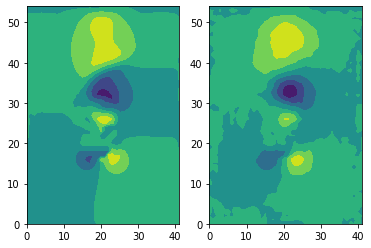

In [11]:
# Let's plot a reconstruction to see if it visually corresponds to what we expect
fig, ax = plt.subplots(1,2)
ax[0].contourf(dataset[92,:,:,1])
ax[1].contourf(recon_dataset[92, :, :, 1])

## Example of using predictive adversarial network on FPC POD coefficients

In [40]:
from ddganAE.models import Predictive_adversarial
from ddganAE.architectures.svdae import *
from ddganAE.architectures.discriminators import *
import tensorflow as tf
import numpy as np

latent_vars = 100  # Define the number of variables the predictive model will use in discriminator layer
n_predicted_vars = 10 # Define the number of predicted variables

dataset = np.load("./../tests/data/pod_coeffs_field_Velocity.npy") # dataset with shape (<ndomains>, <n_latent>, <ntimesteps>)
dataset = np.moveaxis(dataset.reshape(2000, 4, 10),
                                    0, 2) # Convert it to right shape

optimizer = tf.keras.optimizers.Adam() # Define an optimizer
initializer = tf.keras.initializers.RandomNormal() # Define a weights initializer

# Define any encoder and decoder, see docs for more premade architectures. Note for predictive
# models we don't necessarily need to use encoders or decoders
encoder = build_slimmer_dense_encoder(latent_vars, initializer)
decoder = build_slimmer_dense_decoder(n_predicted_vars, latent_vars, initializer)
discriminator = build_custom_discriminator(latent_vars, initializer)

pred_adv = Predictive_adversarial(encoder, decoder, discriminator, optimizer)
pred_adv.compile(n_predicted_vars, increment=False)
pred_adv.train(dataset, 20, val_size=0.1, interval=1)

# Select the boundaries with all timesteps
boundaries = np.zeros((2, 10, dataset.shape[2]))
boundaries[0], boundaries[1]  = dataset[0], dataset[3] # first and fourth subdomains used as boundaries

# Select the initial values at the first timestep
init_values = dataset[1:3, :, 0]

predicted_latent = pred_adv.predict(boundaries, init_values, 200, # Predict 9 steps forward 
                                    iters=4, sor=1, pre_interval=False)

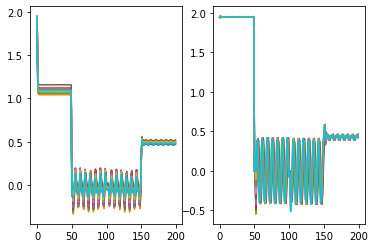

In [42]:
# Let's plot a reconstruction to see if it visually corresponds to what we expect
fig, ax = plt.subplots(1,2)
ax[0].plot(predicted_latent[2, :, :200].T)
ax[1].plot(dataset[2, :, :200].T)

The predictive model is not very good. It needs more samples, epochs, and particular hyperparameters. Also, usually we would rescale the data. Generally, it tends to be much harder to train the predictive model than it is to train the autoencoders.

If you feel comfortable with this notebook check out the other notebooks in the repo! In those notebooks we also use the slug flow dataset and predict its latent variables. However, for those notebooks you do need the full datasets to achieve the same results.